In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotNormal

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import numpy as np
import matplotlib.pyplot as plt

2023-05-03 16:24:05.788922: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-03 16:24:05.845043: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-03 16:24:05.846144: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 16:24:06.929204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
train = pd.read_csv("data/train.csv", delimiter=",")
test = pd.read_csv("data/test.csv", delimiter=",")

In [7]:
train_data = np.array(train, dtype = 'float32')
X_test = np.array(test, dtype='float32')

In [8]:
X_train = train_data[:,1:]/255

y_train = train_data[:,0]

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size = 0.2,random_state = 713)

In [10]:
# plt.figure(figsize=(10, 10))
# for i in range(36):
#     plt.subplot(6, 6, i + 1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(X_train[i].reshape((28,28)))
#     label_index = int(y_train[i])
# plt.show()

In [11]:
image_shape = (28,28,1) 

In [12]:
X_train = X_train.reshape(X_train.shape[0],*image_shape)
X_test = X_test.reshape(X_test.shape[0],*image_shape)

In [22]:
model = keras.Sequential([
    #base
    Conv2D(filters=32,kernel_size=3,activation='relu',input_shape = image_shape),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    #heatete
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=1, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [23]:
history = model.fit(
    X_train, y_train,
    batch_size=512,
    validation_split=0.33,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    epochs=50,
    verbose=1
)

Epoch 1/50
66/66 [==============================] - 9s 122ms/step - loss: 0.7440 - accuracy: 0.7976 - val_loss: 0.2992 - val_accuracy: 0.9093
Epoch 2/50
66/66 [==============================] - 8s 126ms/step - loss: 0.2601 - accuracy: 0.9235 - val_loss: 0.2073 - val_accuracy: 0.9436
Epoch 3/50
66/66 [==============================] - 10s 159ms/step - loss: 0.1898 - accuracy: 0.9449 - val_loss: 0.1603 - val_accuracy: 0.9565
Epoch 4/50
66/66 [==============================] - 14s 217ms/step - loss: 0.1486 - accuracy: 0.9582 - val_loss: 0.1303 - val_accuracy: 0.9638
Epoch 5/50
66/66 [==============================] - 10s 148ms/step - loss: 0.1217 - accuracy: 0.9649 - val_loss: 0.1087 - val_accuracy: 0.9696
Epoch 6/50
66/66 [==============================] - 10s 154ms/step - loss: 0.1017 - accuracy: 0.9710 - val_loss: 0.0940 - val_accuracy: 0.9738
Epoch 7/50
66/66 [==============================] - 9s 137ms/step - loss: 0.0871 - accuracy: 0.9754 - val_loss: 0.0878 - val_accuracy: 0.9737
Ep

In [24]:
test_samp = np.array(test.sample(1)/255)

1/1 [==============================] - 0s 73ms/step
(1, 13, 13, 32)
(1, 13, 13, 32)
(1, 5408)
(1, 32)
(1, 10)


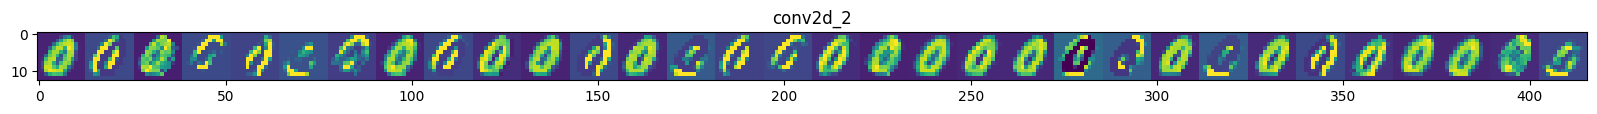

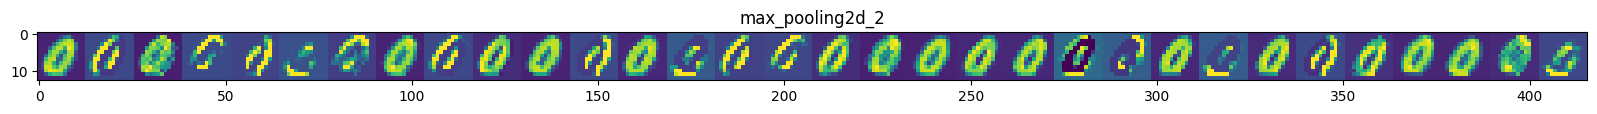

In [25]:
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_feature_maps = visualization_model.predict(test_samp.reshape(1, 28, 28, 1))
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(feature_map.shape)

    if len(feature_map.shape) == 4:

        # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers

        n_features = feature_map.shape[-1]  # number of features in the feature map
        size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))

        # Postprocess the feature to be visually palatable
        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            # Tile each filter into a horizontal grid
            display_grid[:, i * size : (i + 1) * size] = x
        # Display the grid
            scale = 20. / n_features
        fig = plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto', cmap='viridis' )

In [26]:
history_df = pd.DataFrame(history.history)

In [27]:
test_loss, test_acc = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
confusion = confusion_matrix(y_test, y_pred_classes)
print(classification_report(y_test, y_pred_classes))

263/263 [==============================] - 1s 5ms/step
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99       816
         1.0       0.98      0.99      0.99       942
         2.0       0.98      0.97      0.97       880
         3.0       0.97      0.98      0.97       846
         4.0       0.99      0.98      0.98       795
         5.0       0.99      0.97      0.98       778
         6.0       0.99      0.99      0.99       813
         7.0       0.99      0.98      0.98       876
         8.0       0.97      0.97      0.97       796
         9.0       0.97      0.98      0.98       858

    accuracy                           0.98      8400
   macro avg       0.98      0.98      0.98      8400
weighted avg       0.98      0.98      0.98      8400



Text(0.5, 1.0, 'Train - Accuracy')

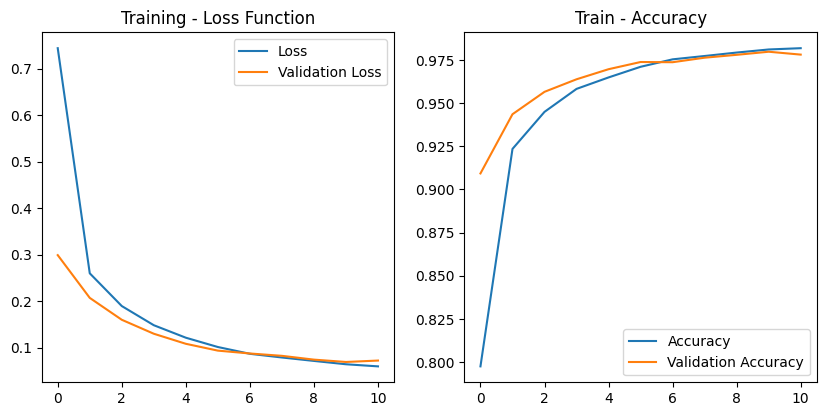

In [28]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training - Loss Function')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Train - Accuracy')

In [29]:
model.save('modail.h5')

In [18]:
new_model = tf.keras.models.load_model('modail.h5')

# new_model.summary()